Вам предоставлены данные о количестве посетителей одного из крупнейших бизнес-центров в Америке. Данные собирались при помощи камер-счётчиков, которые стояли на входе в бц, и фиксировали количество посетителей, которые входили и выходили из бц. Данные предоставлены за $15$ недель с $24/07/2005$ по $05/11/2005$. Также имеется информация о мероприятиях в данном бц, которые проходили в это время.

**Описание данных:**  
* Файл _counters.csv_ - имеет поля _dt_ – дата и время измерения (данные собирались каждые полчаса, то есть за $1$ час имеется $2$ измерения), _cnt_ – количество посетителей;
* Файл _events.csv_ – имеет поля _dt_start_ – дата и время начала события, _dt_end_ –дата и время окончания события, _event_type_ – тип события (здесь тип события = event для всех записей);
* Данные разбиты на train ($24/07/2005$ - $05/10/2005$) и test ($06/10/2005$ – $05/11/2005$);

**Задание:**  
1. Для каждой записи (дата + время) определить, было ли в этот момент какое-то мероприятие или нет (считать, что данные о количестве пользователей на дата + время известны);
2. Реализовать прогноз количества пользователей на тестовой выборке (считать, что информация о предстоящих мероприятиях в будущем (данные из таблицы _events_) нам известна);
3. Реализовать класс, в котором будут методы прогнозирования, метод определения мероприятия и все им необходимые методы для препроцессинга, построения фичей;
4. Ответить на вопросы: Оцените качество решения задач? Какие метрики использовали и почему?


In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score, roc_auc_score

In [220]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [221]:
plt.style.use('seaborn-v0_8-darkgrid')

In [222]:
counters_train = pd.read_csv('counters_train.csv')
counters_test = pd.read_csv('counters_test.csv')

In [223]:
counters_train.head()

,dt,cnt
0,2005-07-24 00:00:00,0
1,2005-07-24 00:30:00,0
2,2005-07-24 01:00:00,0
3,2005-07-24 01:30:00,0
4,2005-07-24 02:00:00,0


In [224]:
counters_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dt      3552 non-null   object
 1   cnt     3552 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.6+ KB


In [225]:
events_train = pd.read_csv('events_train.csv')
events_test = pd.read_csv('events_test.csv')

In [226]:
events_train.head()

,dt_start,dt_end,event_type
0,2005-07-26 11:00:00,2005-07-26 14:00:00,event
1,2005-07-29 08:00:00,2005-07-29 11:00:00,event
2,2005-08-02 15:30:00,2005-08-02 16:30:00,event
3,2005-08-04 16:30:00,2005-08-04 17:30:00,event
4,2005-08-05 08:00:00,2005-08-05 11:00:00,event


In [227]:
events_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dt_start    22 non-null     object
 1   dt_end      22 non-null     object
 2   event_type  22 non-null     object
dtypes: object(3)
memory usage: 656.0+ bytes


In [228]:
# Преобразование столбцов с датами в datetime
counters_train['dt'] = pd.to_datetime(counters_train['dt'])
counters_test['dt'] = pd.to_datetime(counters_test['dt'])
events_train['dt_start'] = pd.to_datetime(events_train['dt_start'])
events_train['dt_end'] = pd.to_datetime(events_train['dt_end'])
events_test['dt_start'] = pd.to_datetime(events_test['dt_start'])
events_test['dt_end'] = pd.to_datetime(events_test['dt_end'])

In [229]:
counters_train.head()

,dt,cnt
0,2005-07-24 00:00:00,0
1,2005-07-24 00:30:00,0
2,2005-07-24 01:00:00,0
3,2005-07-24 01:30:00,0
4,2005-07-24 02:00:00,0


In [230]:
events_train.head()

,dt_start,dt_end,event_type
0,2005-07-26 11:00:00,2005-07-26 14:00:00,event
1,2005-07-29 08:00:00,2005-07-29 11:00:00,event
2,2005-08-02 15:30:00,2005-08-02 16:30:00,event
3,2005-08-04 16:30:00,2005-08-04 17:30:00,event
4,2005-08-05 08:00:00,2005-08-05 11:00:00,event


In [231]:
events_test.head()

,dt_start,dt_end,event_type
0,2005-10-07 09:00:00,2005-10-07 10:30:00,event
1,2005-10-10 16:30:00,2005-10-10 19:00:00,event
2,2005-10-14 09:00:00,2005-10-14 10:30:00,event
3,2005-10-19 22:00:00,2005-10-19 23:30:00,event
4,2005-10-21 09:00:00,2005-10-21 10:30:00,event


In [232]:
# Функция для создания признака наличия события в момент времени
def create_event_feature(counters, events):
    events_arr = np.zeros(len(counters), dtype=int)
    for i in range(len(events)):
        start = events.iloc[i]['dt_start']
        end = events.iloc[i]['dt_end']
        mask = (counters['dt'].values >= start) & (counters['dt'].values <= end)
        
        events_arr[mask] = 1
    counters['event'] = events_arr
    return counters

In [233]:
train_data = create_event_feature(counters_train.copy(), events_train)
test_data = create_event_feature(counters_test.copy(), events_test)

In [234]:
train_data[train_data['event'] > 0]

,dt,cnt,event
118,2005-07-26 11:00:00,1,1
119,2005-07-26 11:30:00,1,1
120,2005-07-26 12:00:00,1,1
121,2005-07-26 12:30:00,1,1
122,2005-07-26 13:00:00,3,1
...,...,...,...
3482,2005-10-04 13:00:00,42,1
3483,2005-10-04 13:30:00,130,1
3484,2005-10-04 14:00:00,115,1
3485,2005-10-04 14:30:00,38,1


In [235]:
class Predictor:
    def __init__(self):
        self.regression_model = CatBoostRegressor(
            iterations=100,
            learning_rate=0.1,
            depth=5,
            silent=True
        )
        self.classification_model = CatBoostClassifier(
            iterations=100,
            learning_rate=0.1,
            depth=3,
            verbose=False
        )
        self.base_time = None
        self.trend_preds = None
        
    def _add_features(self, X, is_classification=False):
        X['quarter'] = X['dt'].dt.quarter
        X['month'] = X['dt'].dt.month
        X['day'] = X['dt'].dt.day
        X['weekday'] = X['dt'].dt.weekday
        X['hour'] = X['dt'].dt.hour
        X['minute'] = X['dt'].dt.minute
        
        X['sin_hour'] = np.sin(2 * np.pi * X['hour'] / 24)
        X['cos_hour'] = np.cos(2 * np.pi * X['hour'] / 24)
        
        if is_classification:
            for i in range(1, 5):
                X[f'lag_{i}'] = X['cnt'].shift(i)
                X[f'lag_{-i}'] = X['cnt'].shift(-i)
            X['expanding_window_4_mean'] = X['cnt'].expanding(6).mean()
            X['expanding_window_8_mean'] = X['cnt'].expanding(12).mean()
            X['expanding_window_12_mean'] = X['cnt'].expanding(24).mean()
        
        return X
    
    def _detrend(self, X, y):
        self.base_time = X['dt'].min()
        X_trend = np.array((X['dt'] - self.base_time).dt.total_seconds() / 3600).reshape(-1, 1)
        y_trend = y.values
        
        # Обучение полиномиальной регрессии для выявления нелинейного тренда
        degree = 2
        trend_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        trend_model.fit(X_trend, y_trend)

        # Получение значений тренда
        trend_values = trend_model.predict(X_trend)

        # Визуализация
        plt.figure(figsize=(15, 6))
        plt.plot(X['dt'], y, color='blue', label='Истинные значения', alpha=0.5)
        plt.plot(X['dt'], trend_values, color='red', label='Линия тренда')
        plt.title('Ретро-данные с линией тренда')
        plt.xticks(ticks=X['dt'].dt.strftime('%Y-%m-%d').unique(), rotation=65)
        plt.xlabel('Дата')
        plt.ylabel('Число посетителей')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return trend_model, trend_values
    
    def _predict_trend(self, X, y, trend_model):
        # Предсказание тренда для тестовых данных
        X_trend = np.array((X['dt'] - self.base_time).dt.total_seconds() / 3600).reshape(-1, 1)
        trend_preds = trend_model.predict(X_trend)
        
        # Визуализация
        plt.figure(figsize=(15, 6))
        plt.plot(X['dt'], y, color='blue', label='Истинные значения', alpha=0.5)
        plt.plot(X['dt'], trend_preds, color='red', label='Линия тренда')
        plt.title('Тестовые данные с предсказанной линией тренда')
        plt.xticks(ticks=X['dt'].dt.strftime('%Y-%m-%d').unique(), rotation=65)
        plt.xlabel('Дата')
        plt.ylabel('Число посетителей')
        plt.legend()
        plt.tight_layout()
        plt.show()
        return trend_model, trend_preds
        
    def fit_visitors(self, X, y):
        self.model = self.regression_model
        trend_model, trend_values = self._detrend(train_data, train_data['cnt'])
        trend_model, trend_preds = self._predict_trend(test_data, test_data['cnt'], trend_model)
        self.trend_preds = trend_preds
        y /= trend_values
        X = self._add_features(X)
        # Обучение модели на детрендированных данных
        self.model.fit(X.drop('dt', axis=1), y)
        preds = self.model.predict(X.drop('dt', axis=1))
        
        # Визуализация
        plt.figure(figsize=(15, 6))
        plt.plot(X['dt'], y, color='blue', label='Истинные значения', alpha=0.5)
        plt.plot(X['dt'], preds, color='red', label='Предсказанные значения')
        plt.title('Результат обучения на детрендированных данных')
        plt.xticks(ticks=X['dt'].dt.strftime('%Y-%m-%d').unique(), rotation=65)
        plt.xlabel('Дата')
        plt.ylabel('Число посетителей')
        plt.legend()
        plt.tight_layout()
        
        return self
    
    def fit_events(self, X, y):
        self.model = self.classification_model
        X = self._add_features(X, is_classification=True)
        self.model.fit(X.drop('dt', axis=1), y)
        return self
    
    def predict_visitors(self, X):
        X = self._add_features(X)
        preds = self.model.predict(X.drop('dt', axis=1))
        # Восстановление тренда
        return np.round(preds * self.trend_preds)
    
    def predict_events(self, X, y):
        X = self._add_features(X, is_classification=True)
        proba = self.model.predict_proba(X.drop('dt', axis=1))[:, 1]
        # Подбор порогового значения
        thresholds = np.linspace(0, 1, 100)
        f1_scores = [f1_score(y, proba > threshold) for threshold in thresholds]
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        preds = (proba > optimal_threshold).astype(int)
        return preds
    
    def show_feature_importance(self):
        feature_names = self.model.feature_names_
        feature_importances = self.model.get_feature_importance()

        importance_df = pd.DataFrame({'features': feature_names, 'importance': feature_importances})
        importance_df = importance_df.sort_values(by='importance', ascending=True)

        # Визуализация значимости признаков модели
        plt.figure(figsize=(15, 6))
        plt.barh(importance_df['features'], importance_df['importance'], color='blue', alpha=0.5)
        plt.xlabel('Важность')
        plt.ylabel('Признаки')
        plt.title('Значимость признаков')
        plt.tight_layout()
        plt.show()

# Предсказание числа посетителей

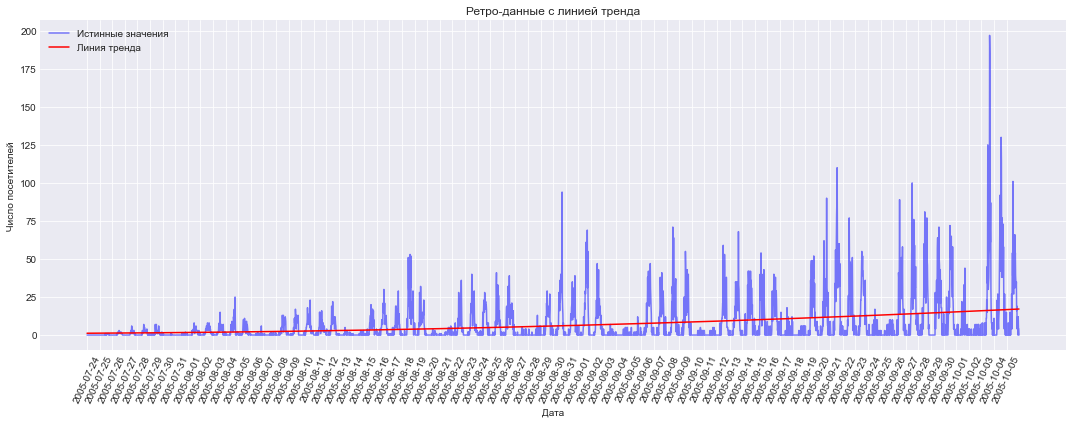

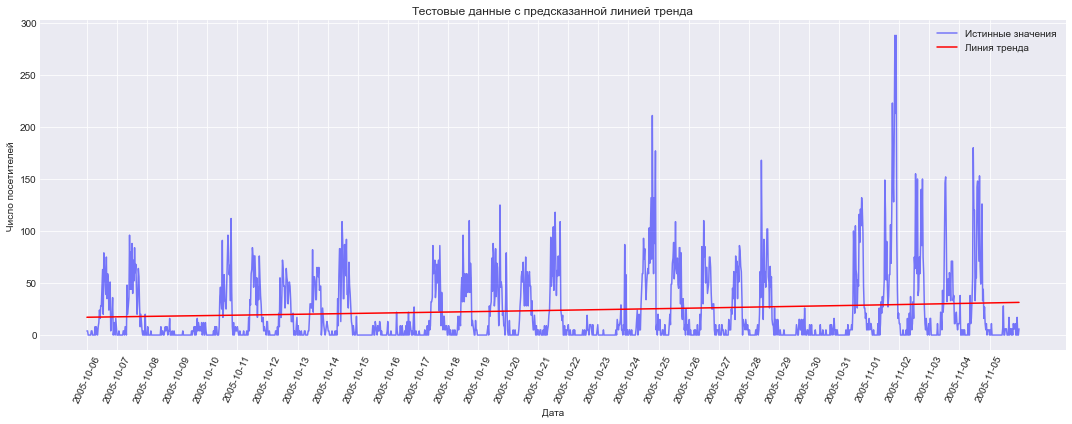

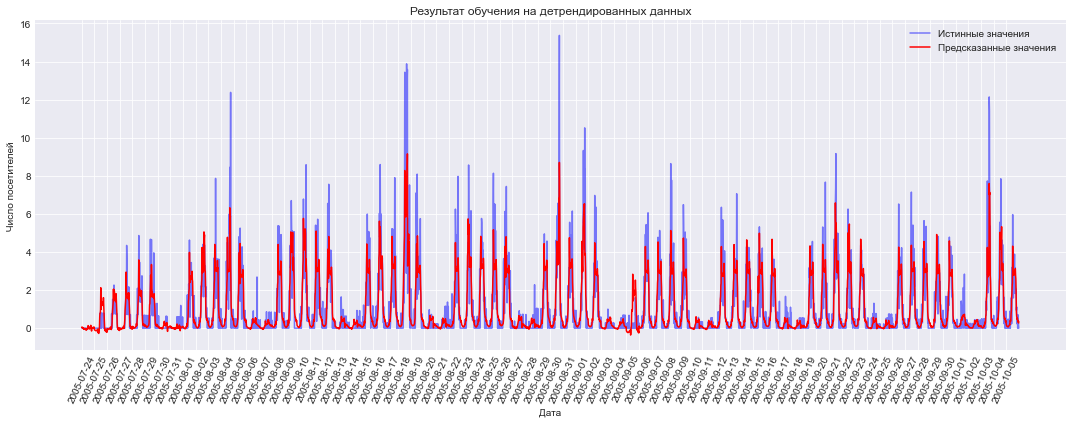

In [236]:
predictor = Predictor()

X_train = train_data[['dt', 'event']]
y_train = train_data['cnt']

predictor.fit_visitors(X_train, y_train)

X_test = test_data[['dt', 'event']]
y_test = test_data['cnt']

preds = predictor.predict_visitors(X_test)

In [237]:
# Оценка модели на тестовых данных
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'mae: {mae}')
print(f'rmse: {rmse}')

mae: 11.666666666666666
rmse: 23.306282322561113


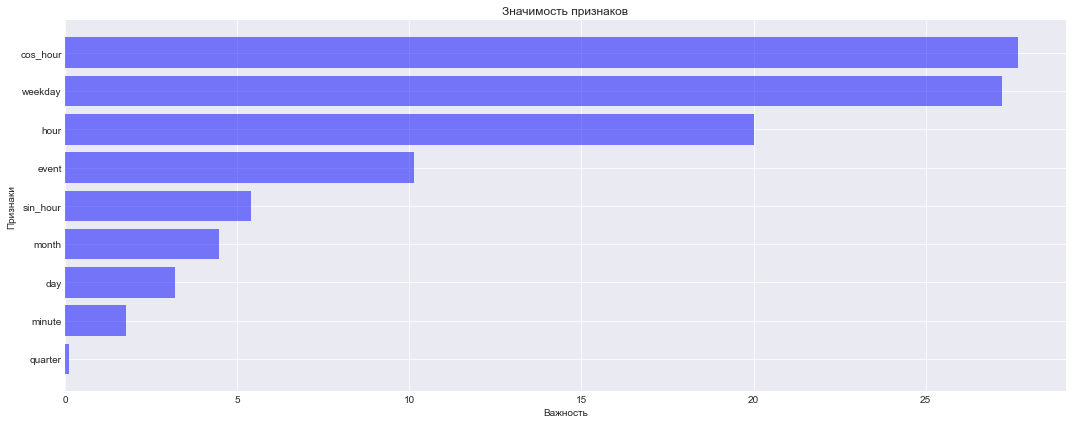

In [238]:
predictor.show_feature_importance()

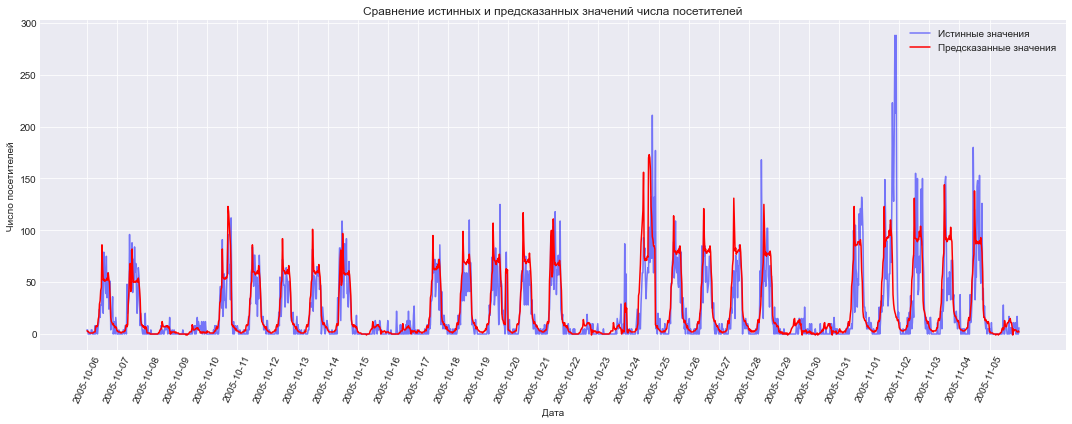

In [239]:
plt.figure(figsize=(15, 6))
plt.plot(test_data['dt'], y_test, label='Истинные значения', color='blue', alpha=0.5)
plt.plot(test_data['dt'], preds, label='Предсказанные значения', color='red')
plt.title('Сравнение истинных и предсказанных значений числа посетителей')
plt.ylabel('Число посетителей')
plt.xlabel('Дата')
plt.xticks(ticks=test_data['dt'].dt.strftime('%Y-%m-%d').unique(), rotation=65)
plt.legend()
plt.tight_layout()
plt.show()

# Предсказание факта проведения мероприятия

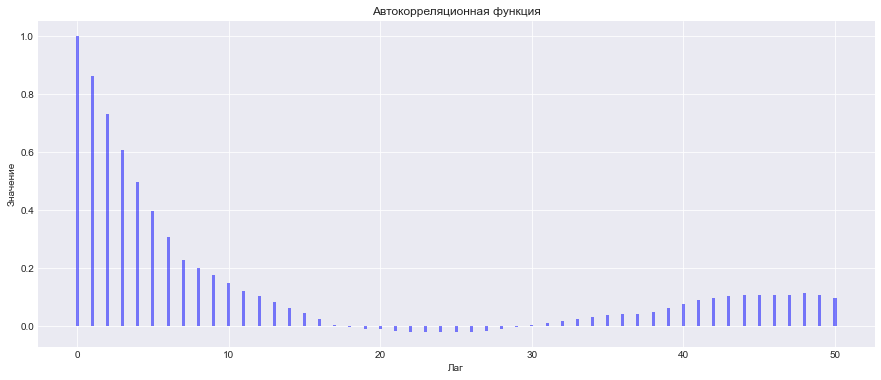

In [240]:
X_train = train_data[['dt', 'cnt']]
y_train = train_data['event']

plt.figure(figsize=(15, 6))
plt.bar(range(51), acf(y_train, nlags=50), color='blue', alpha=0.5, width=0.2)
plt.title('Автокорреляционная функция')
plt.xlabel('Лаг')
plt.ylabel('Значение')
plt.show()

predictor.fit_events(X_train, y_train)

X_test = test_data[['dt', 'cnt']]
y_test = test_data['event']

preds = predictor.predict_events(X_test, y_test)

In [241]:
# Оценка модели на тестовых данных
f1_score = f1_score(y_test, preds)
roc_auc_score = roc_auc_score(y_test, preds)
print(f'f1-score: {f1_score}')
print(f'roc-auc-score: {roc_auc_score}')

f1-score: 0.2222222222222222
roc-auc-score: 0.6454803111620334


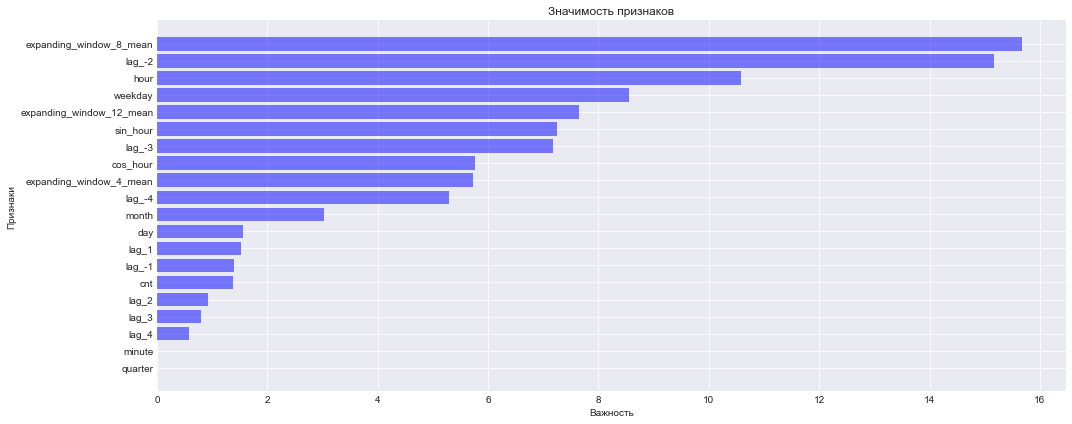

In [242]:
predictor.show_feature_importance()

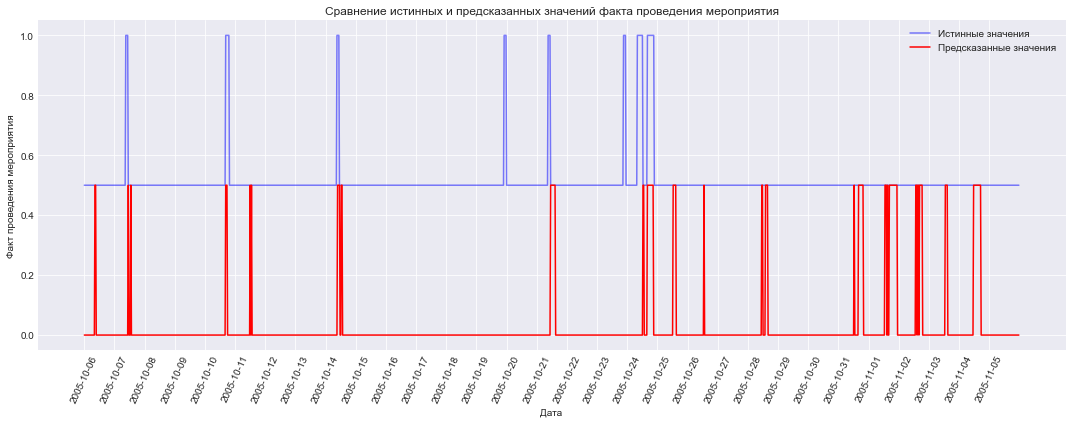

In [243]:
plt.figure(figsize=(15, 6))
plt.plot(test_data['dt'], y_test / 2 + 0.5, label='Истинные значения', color='blue', alpha=0.5)
plt.plot(test_data['dt'], preds / 2, label='Предсказанные значения', color='red')
plt.title('Сравнение истинных и предсказанных значений факта проведения мероприятия')
plt.ylabel('Факт проведения мероприятия')
plt.xlabel('Дата')
plt.xticks(ticks=test_data['dt'].dt.strftime('%Y-%m-%d').unique(), rotation=65)
plt.legend()
plt.tight_layout()
plt.show()

# Выводы

В качестве модели для решения задачи было решено быбрать _CatBoost_.

**Предсказание числа посетителей**  
Изначально модель уже неплохо решала задачу предсказания числа посетителей, однако предикты пиковых значений в дневное время были неудовлетворительными. Были добавлены некоторые экзогенные факторы, а также синусоидальные и косинусоидальные трансформации. Это помогло немного улучшить качество предскания, но пики по-прежнему оставались недосягаемыми. Также нельзя было включить лаговые переменные, поскольку на тесте данные о числе посетителей была недоступны. В итоге было принято решение удалить тренд из исходного ряда, и обучить _CatBoost_ на детрендированных данных. Для выявления тренда на тренировочных данных помогла полиномиальная регрессия: по визуализации было видно, что линейная регрессия справляется с улавливанием тренда, но далеко не идеально. Благодаря учёту явно наблюдавшегося тренда удалось получить неплохие результаты предсказания. Стоит отметить, что предобработка (логарифмирование, преобразование Бокса-Кокса) не дала никаких улучшений, так что данные были оставлены "как есть". 

**Предсказание факта проведения мероприятия**  
Качество решения данной задачи оказалось значительно хуже по сравнению с первой. Здесь уже были доступны данные о числе посетителей на тесте, так что для улучшения качества модели были добавлены лаговые признаки, а также расширяющееся окно (_expanding window_) для расчёта среднего числа посетителей по окну заданной ширины. Это дало буст. Руками были подобраны гиперпараметры, т.к. стало понятно, что смысла "тыкать" в оптуну особого нет. После обучения был подобран _threshold_ для максимизации метрики _F1_-score. В целом, частично удалось получить корректные предсказания положительного класса, но модель предсказала много лишнего. Как ей помочь в этой ситуации – вопрос открытый. В сравнении с обучающими данными, в тестовых мало мероприятий, к тому же их продолжительность отличается. Для улучшения качества прогнозов хочется попробовать статистические модели, а также нейросетевой подход (LSTM обычно хорошо захватывает зависимости в данных).

**Что по метрикам?**  
Для регрессии (прогнозирование числа посетителей) выбор был сделан в пользу _MAE_ и _RMSE_. Первая метрика хорошо интерпретируется. В моём случае модель в среднем ошиблась на 12 посетителей, что является хорошим результатом. _RMSE_ более чувствительна к большим ошибкам за счёт возведения в квадрат. Выбрана для учёта сильных отклонений от фактических значений. Здесь значение получилось тоже приемлемое.  
Для классификации (прогнозирование факта проведения мероприятия) были использованы _F1_-score и _ROC-AUC-score_. Первая метрика учитывает как точность, так и полноту предсказания, что важно в случае несбалансированных классов. Вторая метрика – площадь под _ROC_-кривой, которая отлично интерпретируется. Чем ближе значение к $1$, тем лучше модель различает классы. К сожалению, $0.65$ – максимум, который удалось выжать, используя _CatBoost_.